In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q '/content/drive/MyDrive/BTD_DL.zip'

replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os


In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

class_1 = os.listdir('/content/yes/')
class_0 = os.listdir('/content/no/')

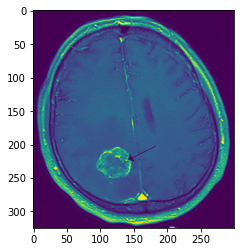

Image size= (325, 300)


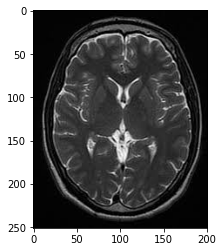

Image size= (251, 201, 3)


In [7]:
example1 = plt.imread('/content/yes/' + class_1[13])
plt.imshow(example1)
plt.show()
print('Image size=', example1.shape)

example0 = plt.imread('/content/no/' + class_0[54])
plt.imshow(example0)
plt.show()
print('Image size=', example0.shape)

In [8]:
os.mkdir('/content/train/')
os.mkdir('/content/test/')
os.mkdir('/content/train/yes/')
os.mkdir('/content/train/no/')
os.mkdir('/content/test/yes/')
os.mkdir('/content/test/no/')

FileExistsError: ignored

In [9]:
import shutil
import random
from sklearn.model_selection import train_test_split
np.random.seed(0)
random.seed(0)
train_1, test_1 = train_test_split(class_1, test_size=0.3,  shuffle = True)
train_0, test_0 = train_test_split(class_0, test_size=0.3, shuffle = True)


for filename in train_1:
    shutil.copy('/content/yes/'+filename, '/content/train/yes/'+filename)

for filename in train_0:
    shutil.copy('/content/no/'+filename, '/content/train/no/'+filename)

for filename in test_1:
    shutil.copy('/content/yes/'+filename, '/content/test/yes/'+filename)

for filename in test_0:
    shutil.copy('/content/no/'+filename, '/content/test/no/'+filename)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train/',
    target_size=(227, 227),
    shuffle = True,
    batch_size=32)

validation_generator = test_datagen.flow_from_directory(
    '/content/test/',
    target_size=(227, 227),
    batch_size=32)

Found 176 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


In [11]:
os.mkdir('preview')

FileExistsError: ignored

In [12]:
x = example1  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
plt.imshow(example1)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augmented Images')
plt.show()

ValueError: ignored

Resnet 18

In [13]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

In [14]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [15]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [16]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,decay=1e-04)

In [17]:
model = ResNet18(2)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
#from tf.keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = opt,loss='categorical_crossentropy', metrics=["accuracy"]) 

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [18]:
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 74368     
 )                                                               
                                                         

In [20]:
history = model.fit(train_generator,
          epochs=100,
          validation_data=validation_generator)

Epoch 1/100
6/6 [==============================] - 3s 554ms/step - loss: 0.5402 - accuracy: 0.7216 - val_loss: 0.7386 - val_accuracy: 0.6104
Epoch 2/100
6/6 [==============================] - 3s 591ms/step - loss: 0.4998 - accuracy: 0.7784 - val_loss: 0.6849 - val_accuracy: 0.6234
Epoch 3/100
6/6 [==============================] - 3s 538ms/step - loss: 0.4782 - accuracy: 0.7500 - val_loss: 0.7700 - val_accuracy: 0.6234
Epoch 4/100
6/6 [==============================] - 3s 530ms/step - loss: 0.4419 - accuracy: 0.8011 - val_loss: 0.7330 - val_accuracy: 0.6234
Epoch 5/100
6/6 [==============================] - 3s 533ms/step - loss: 0.4625 - accuracy: 0.8239 - val_loss: 0.8355 - val_accuracy: 0.6234
Epoch 6/100
6/6 [==============================] - 3s 529ms/step - loss: 0.4625 - accuracy: 0.7898 - val_loss: 0.8422 - val_accuracy: 0.6234
Epoch 7/100
6/6 [==============================] - 3s 537ms/step - loss: 0.4637 - accuracy: 0.7955 - val_loss: 0.9013 - val_accuracy: 0.6234
Epoch 8/100
6

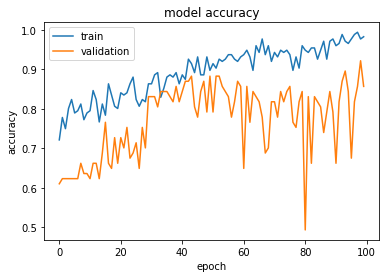

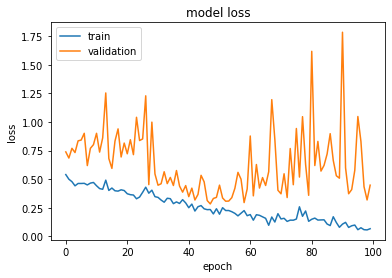

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

In [ ]:
model.evaluate(validation_generator)

In [ ]:
model.evaluate(train_generator)